# Modeling & Baseline Training

In this notebook, we train baseline churn prediction models using the
feature pipeline created in `02_feature_engineering.ipynb`.

Key principles:
- The feature engineering pipeline is **frozen**
- No refitting of the preprocessor occurs here
- Train / validation / test splits are clearly separated
- Evaluation focuses on churn-relevant metrics


Train and compare multiple classification models
for predicting customer churn. Since we do not assume prior knowledge of which
model performs best for this dataset, we evaluate several baseline and advanced
models using consistent data splits and evaluation metrics.


## Evaluation Metrics


Churn prediction is an imbalanced classification problem. We therefore focus on:
- ROC-AUC (overall ranking quality)
- F1-score (balance between precision and recall)
- Precision & Recall (business relevance)


## Imports and Configuration

We import the required libraries for data handling, preprocessing,
model training, and evaluation.


In [1]:
import pandas as pd
import numpy as np

import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

## Load Cleaned Dataset

We load the cleaned dataset produced during feature engineering.
This dataset contains **raw features only** (no transformations applied).

In [2]:
data = pd.read_csv("../data/telco_customer_churn.csv")

X = data.drop(columns=["Churn"])
y = data["Churn"]

## Separate Features and Target

The target variable for this project is `Churn`.
We remove it from the feature matrix before modeling.

In [3]:
X = data.drop(columns=["Churn"])
y = data["Churn"].map({"Yes": 1, "No": 0})


## Train / Validation / Test Split

We split the dataset into training, validation, and test sets
using stratification to preserve the churn rate across splits.


In [4]:
X_train, X_test, y_train, y_test = joblib.load("../data/splits.joblib")


## Load Feature Preprocessor

The preprocessing pipeline was fitted and saved during
`02_feature_engineering.ipynb`.
Here, we only apply `.transform()` to avoid data leakage.


In [5]:
preprocessor = joblib.load("../data/preprocessor.joblib")

## Apply Feature Transformations

We apply the frozen preprocessing pipeline to each data split.
The result is a numeric feature matrix suitable for modeling.


In [6]:
X_train_t = preprocessor.transform(X_train)
X_test_t = preprocessor.transform(X_test)


## Class Balance

We verify that the churn rate is consistent across splits.


In [7]:
pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "test": y_test.value_counts(normalize=True),
})


,train,test
Churn,,
0,0.734254,0.734123
1,0.265746,0.265877


## Baseline Model: Logistic Regression

Logistic Regression provides an interpretable and strong baseline
for churn prediction.


In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)


In [9]:
X = data.drop(columns=["Churn"])
y = data["Churn"].map({"Yes": 1, "No": 0})

# split
# transform
model.fit(X_train_t, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

# Model Development & Comparison

In [10]:
from sklearn.metrics import (
roc_auc_score, f1_score, precision_score, recall_score
)

In [11]:
from sklearn.metrics import roc_auc_score, f1_score


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return {
    "ROC_AUC": roc_auc_score(y_test, y_proba),
    "F1": f1_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred)
}

results = {}

## Advanced Models


We now evaluate several more flexible models that can capture
non-linear relationships and feature interactions.

### Random Forest


Random Forests are ensemble tree-based models that reduce variance
and handle non-linearities well with minimal preprocessing.

In [12]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(
n_estimators=300,
max_depth=None,
class_weight="balanced",
random_state=42,
n_jobs=-1
)


results["Random Forest"] = evaluate_model(
rf, X_train_t, y_train, X_test_t, y_test
)

### Gradient Boosting


Gradient Boosting builds trees sequentially, focusing on correcting
errors made by previous models. It often performs well on tabular data.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier


gb = GradientBoostingClassifier(random_state=42)


results["Gradient Boosting"] = evaluate_model(
gb, X_train_t, y_train, X_test_t, y_test
)

### XGBoost 


XGBoost is a powerful gradient boosting framework optimized for
performance and regularization.

In [14]:
from xgboost import XGBClassifier


xgb = XGBClassifier(
n_estimators=300,
max_depth=6,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
eval_metric="logloss",
random_state=42
)


results["XGBoost"] = evaluate_model(
xgb, X_train_t, y_train, X_test_t, y_test
)

## Model Comparison


The following table summarizes model performance on the test set.

In [15]:
results_df = pd.DataFrame(results).T.sort_values(
by="ROC_AUC", ascending=False
)


results_df

,ROC_AUC,F1,Precision,Recall
Gradient Boosting,0.838195,0.572573,0.652968,0.509804
XGBoost,0.823728,0.558594,0.617711,0.509804
Random Forest,0.811448,0.516854,0.605263,0.450980


## Model Comparison and Selection


Among the evaluated models, Gradient Boosting achieved the strongest
overall performance, with the highest ROC-AUC and F1-score. While XGBoost
performed competitively, it did not outperform Gradient Boosting under
default hyperparameters. Random Forest showed weaker recall and overall
discriminative ability.


Given these results, Gradient Boosting is selected as the current best
model. XGBoost remains a strong candidate for further improvement through
hyperparameter tuning.

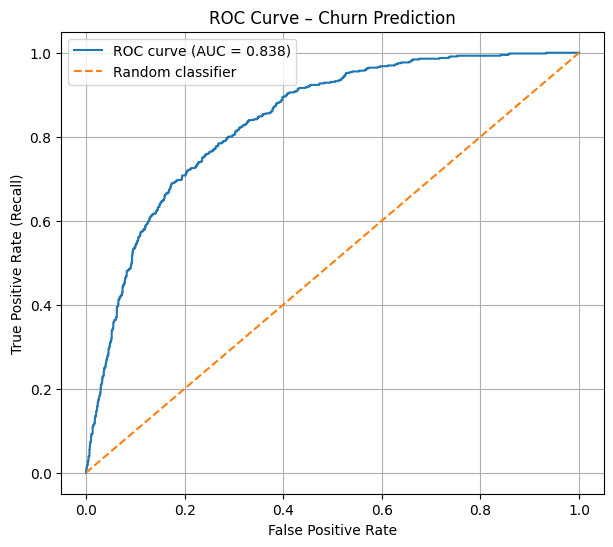

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# predicted probabilities for churn (positive class)
y_proba = model.predict_proba(X_test_t)[:, 1]


# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)


plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Churn Prediction")
plt.legend()
plt.grid(True)


plt.show()

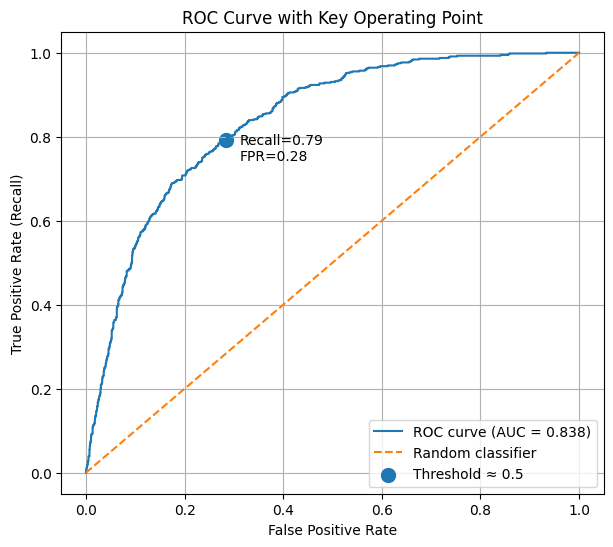

In [17]:
import numpy as np


# find index closest to threshold 0.5
idx_05 = np.argmin(np.abs(thresholds - 0.5))


plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")


# highlight threshold = 0.5
plt.scatter(
fpr[idx_05],
tpr[idx_05],
s=100,
label="Threshold ≈ 0.5"
)


plt.annotate(
f"Recall={tpr[idx_05]:.2f}\nFPR={fpr[idx_05]:.2f}",
(fpr[idx_05], tpr[idx_05]),
textcoords="offset points",
xytext=(10, -15)
)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve with Key Operating Point")
plt.legend()
plt.grid(True)


plt.show()

## ROC Curve Analysis


The ROC curve illustrates the trade-off between true positive rate (recall)
and false positive rate across all classification thresholds. The Gradient
Boosting model achieves a strong ROC-AUC, indicating good overall ranking
ability for churn risk. Business-specific threshold selection can be applied
depending on the acceptable balance between missed churners and unnecessary
retention actions.

## Reusable Functions


In this section, we define functions to **predict churn probabilities** for new data and **evaluate any model** on standard metrics.
These functions are modular, so we can call them multiple times without repeating code.

In [18]:
# --- Imports ---
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import numpy as np

# --- Function 1: Predict churn probabilities ---
def predict_churn(model, X_new):
    """
    Predict churn probabilities for new data.

    Parameters:
    - model: trained ML model (Logistic Regression, XGBoost, etc.)
    - X_new: preprocessed features for prediction (DataFrame, NumPy array, or sparse matrix)

    Returns:
    - np.array of predicted churn probabilities
    """
    return model.predict_proba(X_new)[:, 1]


# --- Function 2: Evaluate model ---
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a model on train and test datasets.

    Computes ROC-AUC, F1 score, Precision, and Recall on test set.

    Returns:
    - Dictionary of metrics
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "ROC_AUC": roc_auc_score(y_test, y_proba),
        "F1": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    }
    return metrics

### Example Usage


We can now test our functions on a **sample of the test data**.

In [19]:
# Sample predictions
sample_row = X_test_t[:1]  # Works for array or sparse matrix
prob = predict_churn(xgb, sample_row)
print(f"Predicted churn probability: {prob[0]:.3f}")

# Evaluate the model on the test set
metrics = evaluate_model(xgb, X_train_t, y_train, X_test_t, y_test)
print("Model Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

Predicted churn probability: 0.048
Model Evaluation Metrics:
ROC_AUC: 0.824
F1: 0.559
Precision: 0.618
Recall: 0.510


### Preparing the Environment for SHAP

SHAP relies on **Numba**, which depends on **llvmlite**. llvmlite sometimes needs to **compile native code** using **LLVM**, and macOS (especially Python 3.11 or Apple Silicon) may require **CMake** to build it.  

To ensure SHAP installs and runs correctly, we need to prepare both the **system** and **Python environment**.

#### Steps Performed
**System-level tools** (install CMake if not already installed):

```bash
# Homebrew installation (system-wide, works for all projects)
brew install cmake git python
```
**Activate venv first**
```bash
source venv/bin/activate
```
**Upgrade pip tools**
```bash
pip install --upgrade pip setuptools wheel
```

In [20]:
import shap

### Create the SHAP explainer

Assuming:

- best_model = trained XGBoost model
- X_train_t = transformed training features (NumPy array)
- X_test_t = transformed test features

In [21]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test_t)

In [22]:
feature_names = preprocessor.get_feature_names_out()

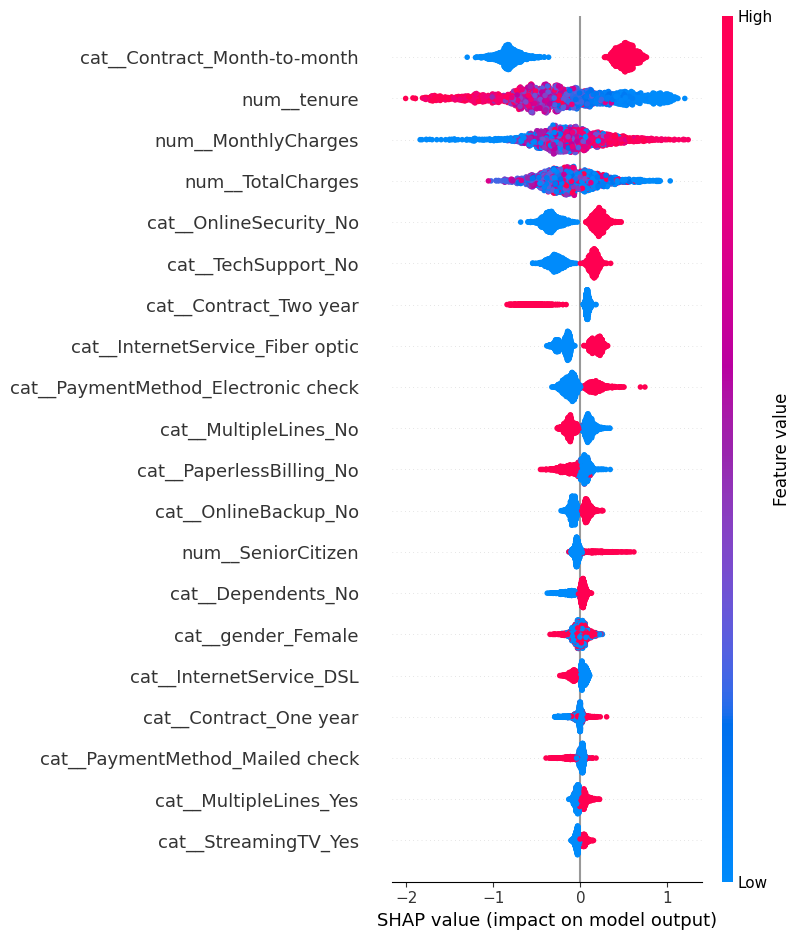

In [23]:
shap.summary_plot(shap_values, X_test_t, feature_names=feature_names)

In [24]:
feature_names = preprocessor.get_feature_names_out()

X_test_df = pd.DataFrame(X_test_t, columns=feature_names)

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test_df)

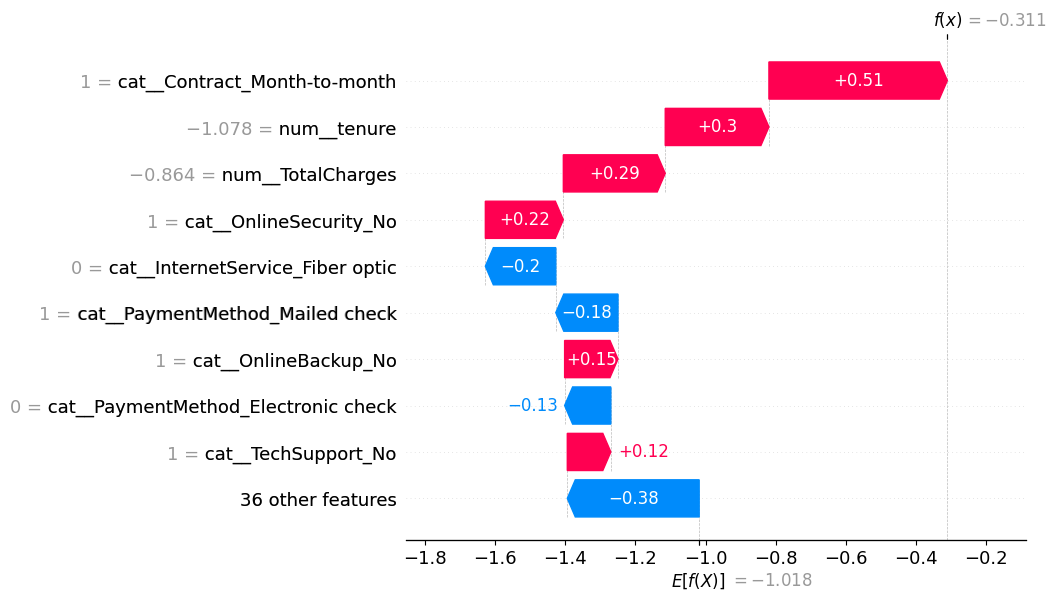

In [26]:
# Select one observation (row index 1) to explain
i = 1

# Plot SHAP waterfall for that observation
shap.plots.waterfall(shap_values[i])


## Interpretation (for this observation):
This customer’s churn risk is mainly driven up by having a month-to-month contract, short tenure, and low total charges, which are the strongest positive contributors. Lack of online security/backup and tech support further increase the prediction. These effects are partially offset by internet service and payment method, but overall the model predicts elevated churn risk for this individual.